In [ ]:
# %%

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import pandas as pd
import scipy
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import mert_ffnn_keras as fn

#This is the .mat file as data frame.
__mat_data__ = scipy.io.loadmat('Xtrain.mat')
    # Convert to DataFrame, there is only one variable in the .mat file
df = pd.DataFrame(__mat_data__['Xtrain']) 

# %% [markdown]

 ## Data Inspection
 We will inspect the data to understand its structure and characteristics in the Xtrain.mat file.
 It contains a single variable, which appears to be sequential data, like a time series.
 See the visualization of the data below:

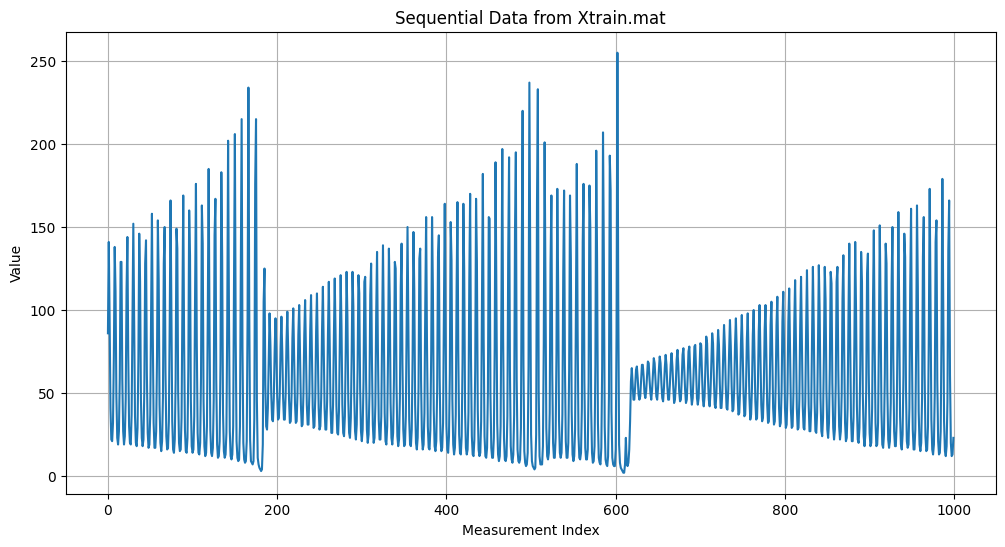

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df[0])
plt.title('Sequential Data from Xtrain.mat')
plt.xlabel('Measurement Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# %% [markdown]

 Check the data for stationarity, which has a stable mean and variance over time.
 It is important to have stationary data to predict the next value.
 Below is a visualisation of the rolling mean and standard deviation.

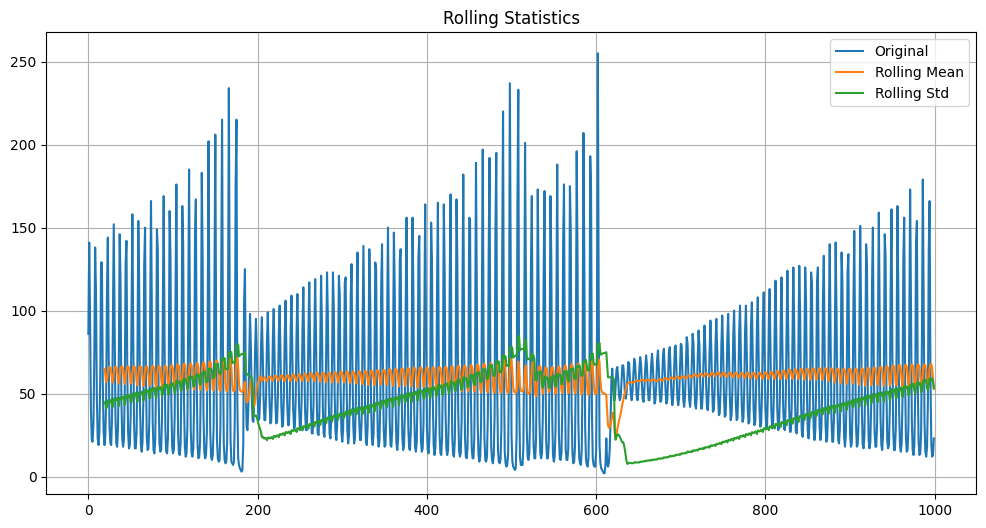

In [ ]:
window_size = 20
rolling_mean = df[0].rolling(window=window_size).mean()
rolling_std = df[0].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(df[0], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Statistics')
plt.grid(True)
plt.show()

# window_size = 7
# rolling_mean = df[0].rolling(window=window_size).mean()
# rolling_std = df[0].rolling(window=window_size).std()

# plt.figure(figsize=(12, 6))
# plt.plot(df[0], label='Original')
# plt.plot(rolling_mean, label='Rolling Mean')
# plt.plot(rolling_std, label='Rolling Std')
# plt.legend()
# plt.title('Rolling Statistics')
# plt.grid(True)
# plt.show()

# %% [markdown]

 Based on the observations, the data appears to be stationary around the mean, but the variance seems to fluctuate.
 Let's perform statistical tests to confirm the stationarity of the data.
 The Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test are commonly used for this purpose.

In [ ]:
# %%

from statsmodels.tsa.stattools import adfuller, kpss

adf_p = adfuller(df[0])[1]
adf_p = round(adf_p, 4)
# ADF Test (null hypothesis: time series is non-stationary)
# If p-value < 0.05, we reject the null hypothesis (data is stationary)
if adf_p < 0.05:
    print(f"ADF test: The data is stationary (p-value = {adf_p:>.3} < 0.05)")
else:
    print(f"ADF test: The data is non-stationary (p-value = {adf_p} >= 0.05)")
    
# KPSS test (null hypothesis: time series is stationary)
# If p-value < 0.05, we reject the null hypothesis (data is non-stationary)
kpss_p = kpss(df[0])[1]
kpss_p = round(kpss_p, 4)
if kpss_p < 0.05:
    print(f"KPSS test: The data is non-stationary (p-value={kpss_p} < 0.05)")
else:
    print(f"KPSS test: The data is stationary (p-value={kpss_p} >= 0.05)")

ADF test: The data is stationary (p-value = 0.0 < 0.05)
KPSS test: The data is stationary (p-value=0.1 >= 0.05)


<ipython-input-4-114498827db2>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(df[0])[1]


# %% [markdown]

 Both tests indicate that the data is stationary, so we can proceed with the inspection,
 no need for differencing or transformation.
 ## Lag Order Selection
 In this type of data, the order of the data points is important, and each data point carries information
 about next data points. However, as the data moves forward, the data points become less relevant, so we need to
 find a balance between how many data points we should remember and how many we should forget.
 It tells us how many previous data points we should consider to predict the next data point.
 Choosing the right lag order is crucial for the performance when working with sequential data.
 We will use 2 methods to evaluate the lag order:
 1. Information Criteria (AIC, BIC, HQIC)
 2. Cross-validation (MSE)
 and compare the results of both methods.

# %% [markdown]

 ### 1. Information Criteria
 We perform auto-regression for each lag order and calculate different loss function for each lag order.
 AIC applies lighter penalty for more parameters than BIC, and HQIC is a compromise between.
 It is common to use AIC if prediction is the goal, BIC is used if a simpler model is desired.

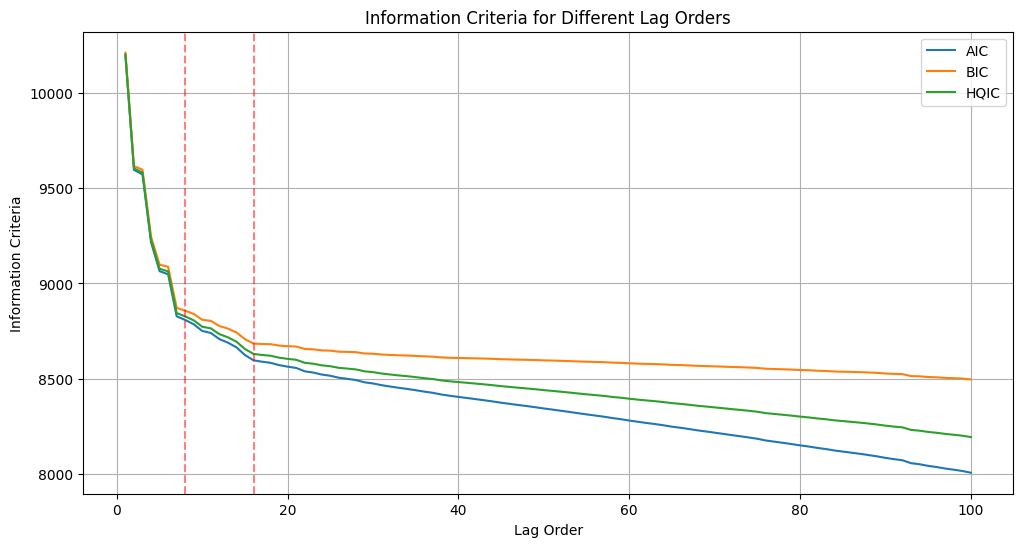

In [ ]:
def evaluate_lag_order(series, max_lag=100):
    # Function to evaluate different lag orders.
    # We picked the trend as 'c' because the data is fluctuating around a stable mean value.
    results = {}
    for lag in range(1, max_lag+1):
        model = AutoReg(series.dropna(), lags=lag, trend='c')
        model_fitted = model.fit()
        results[lag] = {
            'aic': model_fitted.aic,
            'bic': model_fitted.bic,
            'hqic': model_fitted.hqic
        }
    return results

# Evaluate different lag orders
max_lag = 100
lag_evaluation = evaluate_lag_order(df[0], max_lag=max_lag)

# Plot AIC, BIC, HQIC for different lag orders
aics = [lag_evaluation[i]['aic'] for i in range(1, max_lag+1)]
bics = [lag_evaluation[i]['bic'] for i in range(1, max_lag+1)]
hqics = [lag_evaluation[i]['hqic'] for i in range(1, max_lag+1)]
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag+1), aics, label='AIC')
plt.plot(range(1, max_lag+1), bics, label='BIC')
plt.plot(range(1, max_lag+1), hqics, label='HQIC')
plt.axvline(x=8, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=16, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag Order')
plt.ylabel('Information Criteria')
plt.legend()
plt.title('Information Criteria for Different Lag Orders')
plt.grid(True)
plt.show()

# %% [markdown]

 Based on the visual inspection, it look like lag order 7 and 15 are good candidates.
 ### 2. Cross-validation (MSE)
 We will compare different lag order values by using a simple linear model for prediction
 and compare the MSE loss function.

In [ ]:
def time_series_cv(series, max_lag=20, n_splits=10):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = {}
    
    for lag in range(1, max_lag+1):
        mse = []
        for train_idx, test_idx in tscv.split(series):
            train = series.iloc[train_idx]
            test = series.iloc[test_idx]
            
            # Skip if test set is too small for this lag
            if len(test) <= lag:
                continue
            
            # Create lagged features
            X_train = np.array([train.iloc[i-lag:i].values for i in range(lag, len(train))])
            y_train = train.iloc[lag:].values
            
            X_test = np.array([test.iloc[i-lag:i].values for i in range(lag, len(test))])
            y_test = test.iloc[lag:].values
            
            # Simple linear model, Ordinary Least Squares
            model = sm.OLS(y_train, X_train).fit()
            predictions = model.predict(X_test)
            
            mse.append(mean_squared_error(y_test, predictions))
        
        # Only calculate mean if we have values
        if mse:
            mse_scores[lag] = np.mean(mse)
        else:
            # Handle case where no folds were valid for this lag
            mse_scores[lag] = float('nan')  # or some other value
    
    return mse_scores

# Get MSE scores for different lag orders
max_lag = 100
mse_scores_ols = time_series_cv(df[0], max_lag=max_lag, n_splits=5)
# print the min mse score and the corresponding lag order
min_mse_ols = min(mse_scores_ols.values())
best_lag_ols = min(mse_scores_ols, key=mse_scores_ols.get)

# %% [markdown]

 %% [markdown]

Best lag order: 7 with MSE: 445.6011


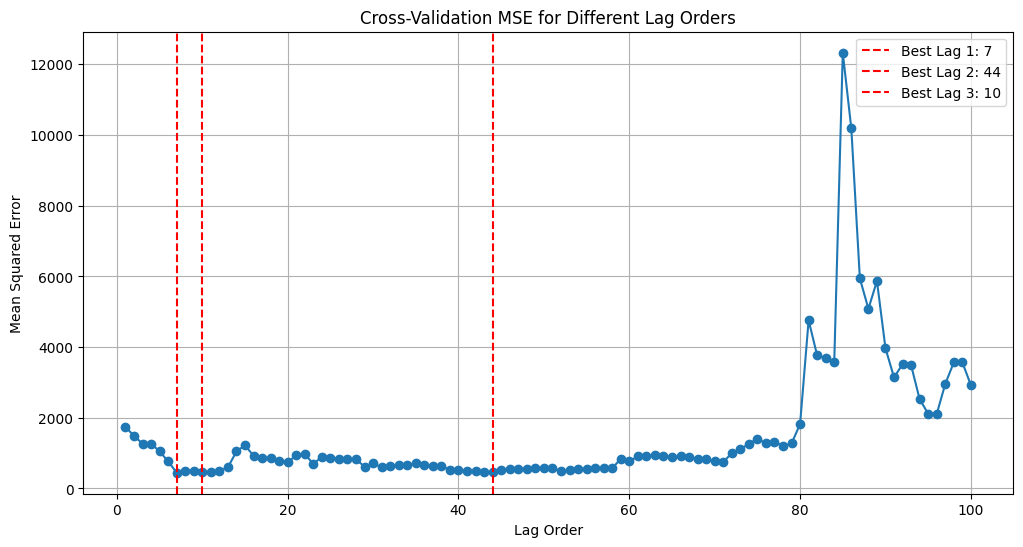

In [ ]:
print(f"Best lag order: {best_lag_ols} with MSE: {min_mse_ols:.4f}")

# Get the 3 lowest MSE values and their corresponding lags
sorted_lags = sorted(mse_scores_ols.items(), key=lambda x: x[1])
best_3_lags_ols = [lag for lag, _ in sorted_lags[:3]]

# Plot MSE for different lag orders
plt.figure(figsize=(12, 6))
plt.plot(list(mse_scores_ols.keys()), list(mse_scores_ols.values()), marker='o')

# Add vertical lines for the 3 best lags
for lag in best_3_lags_ols:
    plt.axvline(x=lag, color='r', linestyle='--', 
                label=f'Best Lag {best_3_lags_ols.index(lag)+1}: {lag}')

plt.xlabel('Lag Order')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation MSE for Different Lag Orders')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]

 ### 3. Neural Network Model Selection and Initial Setup
 The best practice is to use recurrent neural networks (RNN) for sequential data,
 but we decided to use a feedforward neural network (FFNN). Considering the simplicity of the data,
 we argue that a FFNN is sufficient for this task and will be easier to implement.
 We chose the Keras library to implement the FFNN model for the same reason,
 it encapsulates and simplifies the implementation more than the alternatives such as pytorch.
 As FFNN architecture we decided to use a pyramidal structure, which is a common practice based on
 our research. Initially, the model has 3 hidden layers with 128, 64 and 32 neurons and predicts one single
 value. This structure ensures that the model learns many features in the first layer and then reduces
 the number of features, eliminating the less important ones. Dropout layers are added between the hidden layers
 to prevent overfitting. The dropout rate is set to 0.2, which is a common practice.
 We decided to use Adam optimizer with fixed learning rate of 0.001, with maximum number of epochs is set to 200.
 This will ensure that the model has enough time to learn the data, considering that the data is not too large.
 Early stopping is used to stop the training if there is no improvement in the validation loss for 20 epochs to avoid overfitting.
 The batch size is set to 32, which is a common practice for FFNN models. We think that this is a good starting
 point for the model, but we will experiment with different hidden layers and sizes later.

 ### 4. Neural Network Validation MSE for Different Lag Orders
 We'll evaluate different lag orders using our neural network model to determine the best lag order.
 We will use lag orders from 1 to 40, because cross validation with OLS before showed that there is
 no improvement after 40. The dropout will be disabled for this test,
 because we do not want to introduce randomness in the model. We will deal with overfitting later.

Best Neural Network lag order: 14 with Validation MSE: 1.2269


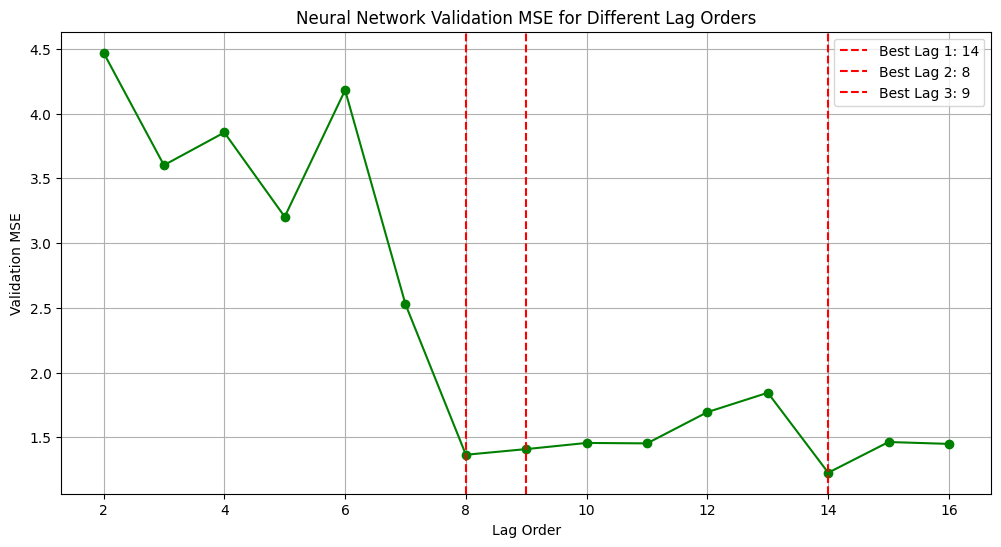

In [ ]:
# %%

print(f"Best Neural Network lag order: {best_nn_lag} with Validation MSE: {best_nn_mse:.4f}")

# remove the first lag from the plot. 
# Because it does not carry any information about past data points and too high. It confuses the plot.
nn_val_mse_scores.pop(1, None)

# Find the 3 lowest MSE values and their corresponding lags
sorted_lags = sorted(nn_val_mse_scores.items(), key=lambda x: x[1])
best_3_lags = [lag for lag, _ in sorted_lags[:3]]

# Plot validation MSE for different lag orders
plt.figure(figsize=(12, 6))
plt.plot(list(nn_val_mse_scores.keys()), list(nn_val_mse_scores.values()), marker='o', color='green')

# Add vertical lines for the 3 best lags
for lag in best_3_lags:
    plt.axvline(x=lag, color='r', linestyle='--', 
                label=f'Best Lag {best_3_lags.index(lag)+1}: {lag}')

plt.xlabel('Lag Order')
plt.ylabel('Validation MSE')
plt.title('Neural Network Validation MSE for Different Lag Orders')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]

 Depending on our experimentation, the variation for neural network starts around lag order 7 for FFNN,
 which can be explained by the overfitting of the model. Please recall that we disabled the dropout to avoid randomness.
 But this still gives a good insight about the lag order when considered together with the information criteria
 and OLS based analysis earlier. We decided to focus on the lag orders 7, 15, 20 and 28 for the final model, based
 on our experimentation and the results of the previous analysis.
 We will enable the dropout again and train the model with these lag orders, 10 times for each lag order and
 average the results, to pick the best lag order.

In [ ]:
# %%

# Convert results to DataFrame
lag_results_df = pd.DataFrame()
for lag in selected_lags:
    lag_results_df[f'Lag {lag}'] = val_mse_trials[lag]

# Add mean row
lag_results_df.loc['Mean'] = lag_results_df.mean()

# Display table
print("\nValidation MSE Results:")
print(lag_results_df.round(4))
# Find the lag order with the lowest mean MSE
best_lag = int(lag_results_df.loc['Mean'].idxmin().split()[1])

# Perform pairwise t-tests between all lag orders
significance_matrix = pd.DataFrame(index=selected_lags, columns=selected_lags)

for lag1 in selected_lags:
    for lag2 in selected_lags:
        if lag1 == lag2:
            significance_matrix.loc[lag1, lag2] = ' '
        else:
            t_stat, p_value = scipy.stats.ttest_ind(val_mse_trials[lag1], val_mse_trials[lag2])
            significance_matrix.loc[lag1, lag2] = 'X' if p_value < 0.05 else '-'

print("\nStatistical Significance Matrix (α=0.05), X = significant:")
print(significance_matrix)

print(f"\nBest lag order based on mean validation MSE: {best_lag}")


Validation MSE Results:
       Lag 7  Lag 15  Lag 20   Lag 28
0     6.6989  9.6429  7.1990   8.5816
1     3.8671  6.8126  9.4074   9.1683
2     6.2840  5.2244  6.4220   8.7189
3     8.0117  6.4326  7.9068  10.1225
4     4.3318  6.2318  6.8285   6.4054
5     6.7902  6.6499  6.2940   5.0868
6     6.0017  7.7366  7.1065   9.9582
7     5.0946  5.6028  7.6694   7.0732
8     6.7546  5.8705  7.9681   7.8825
9     2.9692  3.7883  8.3102   8.8043
Mean  5.6804  6.3992  7.5112   8.1802

Statistical Significance Matrix (α=0.05), X = significant:
   7  15 20 28
7      -  X  X
15  -     -  X
20  X  -     -
28  X  X  -   

Best lag order based on mean validation MSE: 7


# %% [markdown]

 ### 4. Model Structure Experimentation
 Based on the analysis, we can conclude that the best lag order for this data is 7, but in some experiments
 we found that the diffierence between 7 and 15 is not statistically significant.
 Therefore, we will use 7 as the lag order fixed and investigate different model architectures.
 We will experiment with different number of hidden layers and layer sizes and run the model 10 times for each configuration.

In [ ]:
# %%

# Convert results to DataFrame for easier analysis
arch_results_df = pd.DataFrame()
for config, mse_values in architecture_results.items():
    arch_results_df[config] = mse_values

# Add mean row
arch_results_df.loc['Mean'] = arch_results_df.mean()
arch_results_df.loc['Std Dev'] = arch_results_df.std()

# Get the means and standard deviations for each architecture
means = arch_results_df.loc['Mean']
stdevs = arch_results_df.loc['Std Dev']

# Create a DataFrame with means and standard deviations
arch_comparison = pd.DataFrame({
    'Mean MSE': means,
    'Std Dev': stdevs
})

# Sort by mean MSE and get top 5
best_5_architectures = arch_comparison.sort_values('Mean MSE').head(5)

print("\nTop 5 Architectures:")
print(best_5_architectures.round(4))

# Perform pairwise t-tests between the top 4 architectures
top_4_names = best_5_architectures.index

# significance_matrix = pd.DataFrame(index=top_4_names, columns=top_4_names)

# for arch1 in top_4_names:
#     for arch2 in top_4_names:
#         if arch1 == arch2:
#             significance_matrix.loc[arch1, arch2] = ' '
#         else:
#             t_stat, p_value = scipy.stats.ttest_ind(
#                 arch_results_df[arch1], 
#                 arch_results_df[arch2]
#             )
#             significance_matrix.loc[arch1, arch2] = 'X' if p_value < 0.05 else '-'

# print("\nStatistical Significance Matrix for Top 4 Architectures (α=0.05), X = significant:")
# print(significance_matrix)

# Select best architecture based on lowest mean MSE
best_architecture = best_5_architectures.index[0]
print(f"\nBest architecture based on mean validation MSE: {best_architecture}")
# Extract the best model parameters
# Extract parameters
lag_order = 7
num_layers = int(best_architecture.split()[0])
layer_size = int(best_architecture.split()[2])
dropout = 0.2


Top 5 Architectures:
                       Mean MSE  Std Dev
2 layers, 128 neurons    4.2615   0.6607
1 layers, 128 neurons    4.5581   1.2507
3 layers, 128 neurons    5.1534   0.9289
1 layers, 64 neurons     6.7967   1.0160
2 layers, 64 neurons     7.8773   1.7956

Best architecture based on mean validation MSE: 2 layers, 128 neurons


# %% [markdown]

 ## Final Model
 Based on the analysis, we can conclude that the best lag order for this data is 7,
 and the best architecture is 2 hidden layers with 128 and 64. We built the best model based on our analysis and
 perform the training and evaluation.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


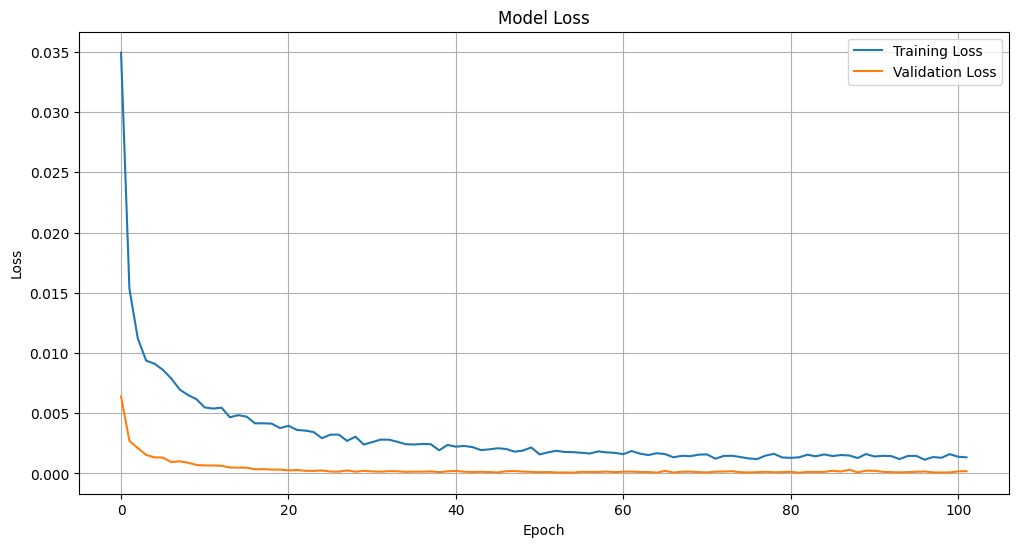

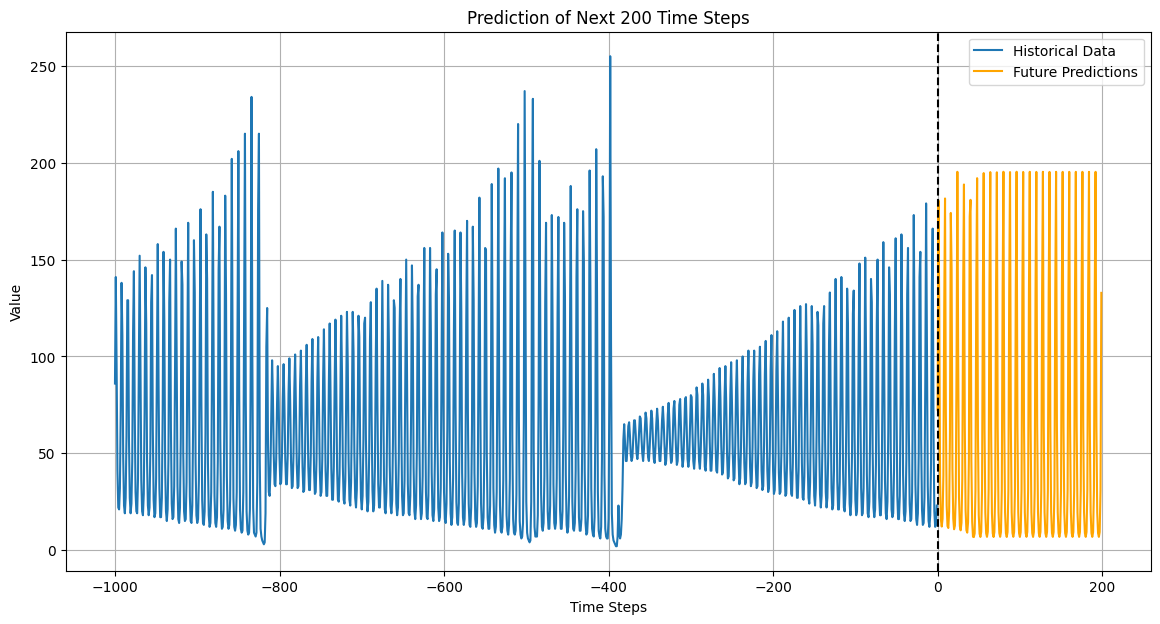

In [ ]:
best_model = fn.build_ffnn_model(input_dim=lag_order, num_layers=num_layers, initial_size=layer_size,drop_out=dropout)
# Train the model and get the training history
results = fn.train(model=best_model, full_dataset=df, lag_order=lag_order)
history = results["history"]
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict the next 200 values
pred_horizon = 200
# Generate future predictions
future_predictions = fn.generate_future_predictions(best_model, lag_order, pred_horizon)
# Get the existing data for plotting context
historical_data = df.values
# Plot the future predictions with historical data
plt.figure(figsize=(14, 7))
# Plot some historical data for context
plt.plot(range(-len(historical_data), 0), historical_data, label='Historical Data')
# Plot the predictions
plt.plot(range(0, pred_horizon), future_predictions, label='Future Predictions', color='orange')
plt.axvline(x=0, color='k', linestyle='--')
plt.title(f'Prediction of Next {pred_horizon} Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()